In [16]:
import pandas as pd
import numpy as np
import scipy.stats as sc
import matplotlib.pyplot as plt

In [3]:
data = pd.read_csv('diabetes.txt', sep = " ")
data.head()

,age,sex,bmi,map,tc,ldl,hdl,tch,ltg,glu,y
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646,151
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204,75
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930,141
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362,206
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641,135


In [4]:
# This is the good data
data.shape

(442, 11)

In [7]:
# Define X and Y arrays
X = data.iloc[:,:data.shape[1]-1]
Y = data.iloc[:,data.shape[1]-1].to_numpy()

In [8]:
X.head()

,age,sex,bmi,map,tc,ldl,hdl,tch,ltg,glu
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641


In [10]:
# We center the Y
Y_tilde = Y - Y.mean(axis=0)

The Gibbs sampler used here uses the following full conditional distributions:

- The full conditional for $\beta$ is:

<h3 align="center"> $\mathcal{N}_p(A^{-1}X^T\tilde{y}, \sigma^2A^{-1})$ where $A = X^TX+D^{-1}_\tau$ and $D_\tau = diag(\tau^2_1,...,\tau^2_p)$ </h3>

- The full conditional for $\sigma^2$ is:

<h3 align="center"> $\mathcal{I}nverse\mathcal{G}amma(\frac{n-1+p}{2}, \frac{(\tilde{y}-X\beta)^T(\tilde{y}-X\beta) + \beta^TD^{-1}_\tau\beta}{2})$ </h3>

- $\tau^2_1, ..., \tau^2_p$ are conditionnaly independent and $\frac{1}{\tau^2_j}$ has as conditional distribution:

<h3 align="center"> $\mathcal{I}nverse\mathcal{G}ausian(\sqrt{\frac{\lambda^2\sigma^2}{\beta^2_j}}, \lambda^2)$ </h3>


In [11]:
def Gibbs_sampler(n, lambda_):
    # Initialization
    beta = [np.random.uniform(size = X.shape[1])]
    sigma_sq = [np.random.uniform()]
    tau_sq = [np.random.uniform(size = X.shape[1])]
    for i in range(n):
        # Full conditional for beta
        D_tau = np.diag(tau_sq[i])
        A = X.transpose().dot(X) + np.linalg.inv(D_tau)
        multi_norm_mean = np.linalg.inv(A).dot(X.transpose()).dot(Y_tilde)
        multi_norm_cov = sigma_sq[i] * np.linalg.inv(A)
        beta.append(np.random.multivariate_normal(multi_norm_mean, multi_norm_cov))
        # Full conditional for sigma_sq
        shape = (X.shape[0]-1+X.shape[1])/2
        scale = ((Y_tilde - X.dot(beta[i+1])).dot((Y_tilde - X.dot(beta[i+1]))) + beta[i+1].transpose().dot(np.linalg.inv(D_tau)).dot(beta[i+1]))/2
        sigma_sq.append(sc.invgamma.rvs(a = shape, scale = scale))
        # Full conditional for tau_1,...,tau_p
        mean = np.sqrt(lambda_**2*sigma_sq[i+1]/beta[i+1]**2)
        scale = np.repeat(lambda_**2, X.shape[1])
        tau_sq.append(1/np.random.wald(mean, scale))
    return tau_sq[int(n/2):]

#### Empirical Bayes by Marginal Maximum Likelihood

For the Bayesian Lasso, each iteration of the algorithm involves running the Gibbs sampler using a $\lambda$ value estimated from the sample of the previous iteration. Specifically, iteration $k$ uses the Gibbs sampler of Section 2 with hyperparameter $\lambda^{(k-1)}$ (i.e., the estimate from iteration $k-1$) to approximate the ideal updated estimate:

<h3 align="center"> $\lambda^{(k)} = \sqrt{\frac{2p}{\sum\limits^p_{j=1}E_{\lambda^{(k-1)}}[\tau^2_j|\tilde{y}]}}$ </h3>

by replacing the conditional expectations with averages from the Gibbs sample. We suggest the initial value:

<h3 align="center"> $\lambda^{(0)} = \frac{p\sqrt{\hat{\sigma}^2_{LS}}}{\sum\limits^p_{j=1}|\hat{\beta}^{LS}_j|}$ </h3>

where $\hat{\sigma}^2_{LS}$ and $\hat{\beta}^{LS}_j$ are estimates from the usual least squares procedure.


In [12]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(X,Y_tilde)

LinearRegression()

In [13]:
# Lambda_init
lambda_init = (X.shape[1]*np.sqrt((np.sum((Y_tilde - lm.predict(X))**2))/(X.shape[0]-X.shape[1])))/np.sum(np.abs(lm.coef_))

In [38]:
K = 30  # number of EB iterations
lambda_path = [lambda_init]

lambda_ = lambda_init
for k in range(1, K+1):
    lambda_ = np.sqrt(2*X.shape[1]/sum(np.mean(Gibbs_sampler(1000, lambda_), axis=0)))
    lambda_path.append(lambda_)

In [39]:
lambda_

0.23675287279320367

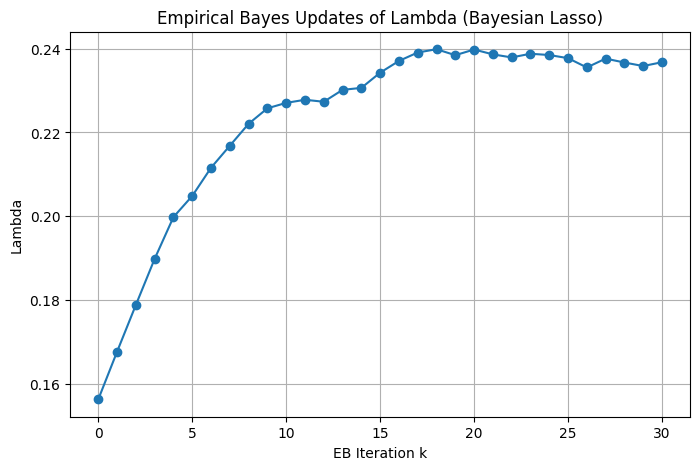

In [40]:
plt.figure(figsize=(8,5))
plt.plot(lambda_path, marker='o')
plt.xlabel("EB Iteration k")
plt.ylabel("Lambda")
plt.title("Empirical Bayes Updates of Lambda (Bayesian Lasso)")
plt.grid(True)
plt.show()


#### Hyperpriors for the Lasso Parameter

We need to modify the previous Gibbs sampler by introducing the full conditional distribution of $\lambda^2$, which is:

<h3 align="center"> $\mathcal{G}amma(p+r, \frac{\sum\limits_{j=1}^p\tau^2_j}{2}+\delta)$ </h3>


In [41]:
def Gibbs_sampler_bis(n, r, delta):
    # Initialization
    beta = [np.random.uniform(size = X.shape[1])]
    sigma_sq = [np.random.uniform()]
    tau_sq = [np.random.uniform(size = X.shape[1])]
    lambda_sq = [np.random.uniform()]
    for i in range(n):
        # Full conditional for beta
        D_tau = np.diag(tau_sq[i])
        A = X.transpose().dot(X) + np.linalg.inv(D_tau)
        multi_norm_mean = np.linalg.inv(A).dot(X.transpose()).dot(Y_tilde)
        multi_norm_cov = sigma_sq[i] * np.linalg.inv(A)
        beta.append(np.random.multivariate_normal(multi_norm_mean, multi_norm_cov))
        # Full conditional for sigma_sq
        shape = (X.shape[0]-1+X.shape[1])/2
        scale = ((Y_tilde - X.dot(beta[i+1])).dot((Y_tilde - X.dot(beta[i+1]))) + beta[i+1].transpose().dot(np.linalg.inv(D_tau)).dot(beta[i+1]))/2
        sigma_sq.append(sc.invgamma.rvs(a = shape, scale = scale))
        # Full conditional for tau_1,...,tau_p
        mean = np.sqrt(lambda_sq[i]*sigma_sq[i+1]/beta[i+1]**2)
        scale = np.repeat(lambda_sq[i], X.shape[1])
        tau_sq.append(1/np.random.wald(mean, scale))
        # Full conditional for lambda_sq
        shape = X.shape[1] + r
        rate = sum(tau_sq[i+1])/2+delta
        lambda_sq.append(np.random.gamma(shape, 1/rate))
    return lambda_sq

In [42]:
lambda_sq_bis = Gibbs_sampler_bis(10000, 1, 1.78)
np.median([np.sqrt(i) for i in lambda_sq_bis])

0.2723022064945825

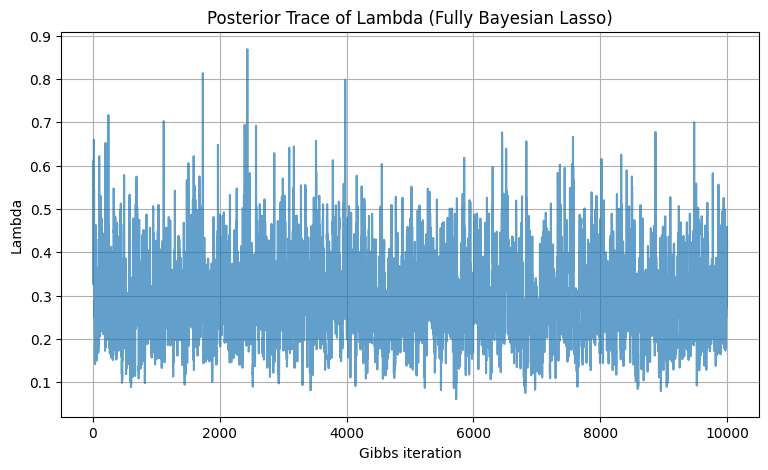

In [22]:
lambda_bis = np.sqrt(lambda_sq_bis)

plt.figure(figsize=(9,5))
plt.plot(lambda_bis, alpha=0.7)
plt.xlabel("Gibbs iteration")
plt.ylabel("Lambda")
plt.title("Posterior Trace of Lambda (Fully Bayesian Lasso)")
plt.grid(True)
plt.show()


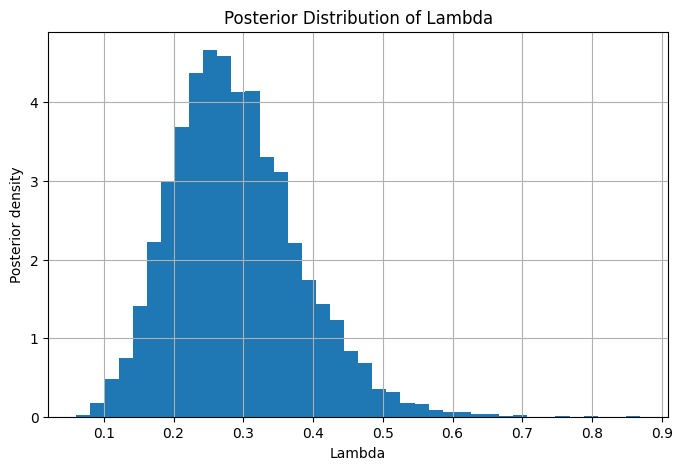

In [23]:
burn = 2000
lambda_post = lambda_bis[burn:]

plt.figure(figsize=(8,5))
plt.hist(lambda_post, bins=40, density=True)
plt.xlabel("Lambda")
plt.ylabel("Posterior density")
plt.title("Posterior Distribution of Lambda")
plt.grid(True)
plt.show()


## 2 Graph of the paper


#### Compute Bayesian lasso coefficients with corresponding lambda\_ (selected according to marginal maximum likelihood)


In [43]:
def Gibbs_sampler_lambda(n, lambda_):
    # Initialization
    beta = [np.random.uniform(size = X.shape[1])]
    sigma_sq = [np.random.uniform()]
    tau_sq = [np.random.uniform(size = X.shape[1])]
    for i in range(n):
        # Full conditional for beta
        D_tau = np.diag(tau_sq[i])
        A = X.transpose().dot(X) + np.linalg.inv(D_tau)
        multi_norm_mean = np.linalg.inv(A).dot(X.transpose()).dot(Y_tilde)
        multi_norm_cov = sigma_sq[i] * np.linalg.inv(A)
        beta.append(np.random.multivariate_normal(multi_norm_mean, multi_norm_cov))
        # Full conditional for sigma_sq
        shape = (X.shape[0]-1+X.shape[1])/2
        scale = ((Y_tilde - X.dot(beta[i+1])).dot((Y_tilde - X.dot(beta[i+1]))) + beta[i+1].transpose().dot(np.linalg.inv(D_tau)).dot(beta[i+1]))/2
        sigma_sq.append(sc.invgamma.rvs(a = shape, scale = scale))
        # Full conditional for tau_1,...,tau_p
        mean = np.sqrt(lambda_**2*sigma_sq[i+1]/beta[i+1]**2)
        scale = np.repeat(lambda_**2, X.shape[1])
        tau_sq.append(1/np.random.wald(mean, scale))
    return beta[int(n/2):]

In [44]:
Gibbs_sampler_lambda_ = Gibbs_sampler_lambda(100000, lambda_)

In [45]:
bayesian_lasso_coef_ml = np.median(Gibbs_sampler_lambda_, axis=0)

In [46]:
coef_sample = []
for i in range(X.shape[1]):
    coef_sample.append(np.asarray(np.matrix(Gibbs_sampler_lambda_)[:,i]).ravel())

In [47]:
# Function to get credible intervals
def calc_min_interval(x, alpha):
    """Internal method to determine the minimum interval of a given width
    Assumes that x is sorted numpy array.
    """

    n = len(x)
    cred_mass = 1.0-alpha

    interval_idx_inc = int(np.floor(cred_mass*n))
    n_intervals = n - interval_idx_inc
    interval_width = x[interval_idx_inc:] - x[:n_intervals]

    if len(interval_width) == 0:
        raise ValueError('Too few elements for interval calculation')

    min_idx = np.argmin(interval_width)
    hdi_min = x[min_idx]
    hdi_max = x[min_idx+interval_idx_inc]
    return hdi_max, hdi_min

In [48]:
confint_ = []
for i in range(X.shape[1]):
    confint_.append(calc_min_interval(np.sort(coef_sample[i]),0.05))

#### Compute Bayesian lasso coefficients with corresponding lambda\_ (Hyperpriors for the Lasso Parameter)


In [49]:
def Gibbs_sampler_lambda_bis(n, r, delta):
    # Initialization
    beta = [np.random.uniform(size = X.shape[1])]
    sigma_sq = [np.random.uniform()]
    tau_sq = [np.random.uniform(size = X.shape[1])]
    lambda_sq = [np.random.uniform()]
    for i in range(n):
        # Full conditional for beta
        D_tau = np.diag(tau_sq[i])
        A = X.transpose().dot(X) + np.linalg.inv(D_tau)
        multi_norm_mean = np.linalg.inv(A).dot(X.transpose()).dot(Y_tilde)
        multi_norm_cov = sigma_sq[i] * np.linalg.inv(A)
        beta.append(np.random.multivariate_normal(multi_norm_mean, multi_norm_cov))
        # Full conditional for sigma_sq
        shape = (X.shape[0]-1+X.shape[1])/2
        scale = ((Y_tilde - X.dot(beta[i+1])).dot((Y_tilde - X.dot(beta[i+1]))) + beta[i+1].transpose().dot(np.linalg.inv(D_tau)).dot(beta[i+1]))/2
        sigma_sq.append(sc.invgamma.rvs(a = shape, scale = scale))
        # Full conditional for tau_1,...,tau_p
        mean = np.sqrt(lambda_sq[i]*sigma_sq[i+1]/beta[i+1]**2)
        scale = np.repeat(lambda_sq[i], X.shape[1])
        tau_sq.append(1/np.random.wald(mean, scale))
        # Full conditional for lambda_sq
        shape = X.shape[1] + r
        rate = sum(tau_sq[i+1])/2+delta
        lambda_sq.append(np.random.gamma(shape, 1/rate))
    return beta[int(n/2):]

In [50]:
bayesian_lasso_coef_hyp = np.median(Gibbs_sampler_lambda_bis(10000, 1, 1.78), axis=0)

#### Lasso estimates based on n-fold cross validation


In [51]:
from sklearn import linear_model
lasso = linear_model.LassoCV()
lasso.fit(X, Y_tilde)

# The estimator chose automatically its lambda:
lasso_cv_coef = lasso.coef_

#### Estimates of ordinary least squares


In [52]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(X,Y_tilde)
least_squares_coef = lm.coef_

Text(0.02, 0.02, '(1) with λ selected according to marginal maximum likelihood\n(2) λ selected according to marginal maximum likelihood\n(3) λ selected using hyperpriors for the Lasso Parameter')

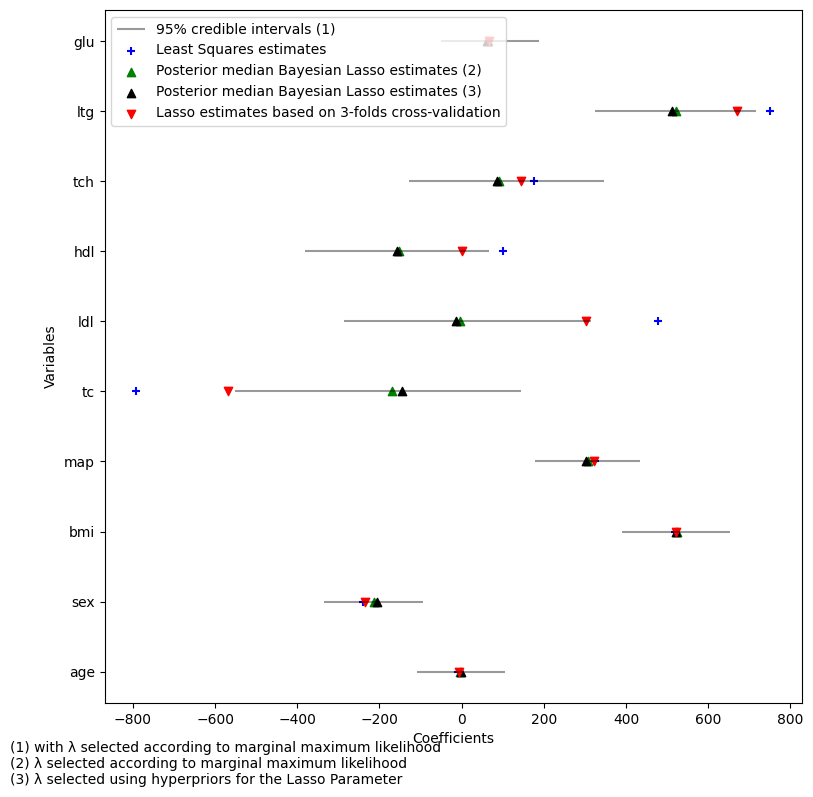

In [53]:
%matplotlib inline
import matplotlib.pyplot as plt


df = pd.DataFrame({'variables':list(data.columns[:-1]), 'Least Squares':least_squares_coef, 'Bayesian Lasso ml':bayesian_lasso_coef_ml,'Bayesian Lasso hyp':bayesian_lasso_coef_hyp , 'CV Lasso':lasso_cv_coef, 'min_cred_int':[i[0] for i in confint_], 'max_cred_int':[i[1] for i in confint_]})
my_range=range(1,len(df.index)+1)

plt.figure(figsize=(9,9))
# The vertical plot is made using the hline function
# I load the seaborn library only to benefit the nice looking feature
import seaborn as sns
plt.hlines(y=my_range, xmin=df['min_cred_int'], xmax=df['max_cred_int'], color='black', alpha=0.4, label='95% credible intervals (1)')
plt.scatter(df['Least Squares'], my_range, color='blue', alpha=1, label='Least Squares estimates', marker='+')
plt.scatter(df['Bayesian Lasso ml'], my_range, color='green', alpha=1 , label='Posterior median Bayesian Lasso estimates (2)', marker='^')
plt.scatter(df['Bayesian Lasso hyp'], my_range, color='black', alpha=1 , label='Posterior median Bayesian Lasso estimates (3)', marker='^')
plt.scatter(df['CV Lasso'], my_range, color='red', alpha=1 , label='Lasso estimates based on 3-folds cross-validation', marker='v')
plt.legend(loc=2, fontsize='medium')

# Add title and axis names
plt.yticks(my_range, df['variables'])
plt.title("", loc='center')
plt.xlabel('Coefficients')
plt.ylabel('Variables')
plt.figtext(.02, .02, "(1) with λ selected according to marginal maximum likelihood\n(2) λ selected according to marginal maximum likelihood\n(3) λ selected using hyperpriors for the Lasso Parameter")